# GW_transient_compare
### This now does many things but all are related to handling Gravitational Wave (GW) localization maps and DESI observations.
### Most generally, this finds those observations in the area of a specified confidence interval (CI) of the GW map.
### It also does the following:
1. Finds *not-previously-observed* ALERCE alerts in the area and creates a ToO ledger for those.
2. Identifies Bright and Dark targets in the CI contour.
3. Compares previous observations with dr9 targets in the CI contour to find the dr9 targets not already observed. Can perform this comparison by matching the targetids or by matching the RA's and DEC's which we feel is slightly more robust.
4. A bit of plotting but it takes awhile to produce a proper cartesian map, be forewarned.

In [1]:
import sys
# For importing useful functions
sys.path.append('/global/homes/p/portmanm/timedomain/gwtarget/')

from astropy.io import fits
from astropy.table import Table, Column, join, hstack, vstack, unique, setdiff
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky, Angle
from astropy.time import Time

from gw_skymap import plot_mollmap, compute_quantiles, compute_contours #, plot_cartmap
from desitarget import io, cuts

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pandas as pd
import glob
import sys

import sqlite3
import os

# Some handy, frequently used things
global db_filename
db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'
global exposure_path
exposure_path = os.environ["DESI_SPECTRO_REDUX"]
global color_band
color_band = "r"
global today
today = Time.now()

## Some function definitions which are hopefully self-explanatory

In [2]:
# From decam_TAMU_ledgermaker.ipynb - https://github.com/desihub/timedomain/blob/master/too_ledgers/decam_TAMU_ledgermaker.ipynb
# Thanks Antonella!

def write_too_ledger(filename, too_table, checker, overwrite=False, verbose=False, tabformat='TAMU'):
    """Write ToO ledger in the ECSV format specified by Adam Meyers.
    These can be passed to fiberassign for secondary targeting.
    
    Parameters
    ----------
    filename : str
        Output filename of the ledger (can be an absolute path).
    too_table : pandas.DataFrame
        Table of ToO data, using DECam format.
    checker : str
        Initials of individual(s) who have verified the ToO list.
    overwrite : bool
        If True, overwrite the output file.
    verbose : bool
        If True, 
    """
    mode = 'w' if overwrite else 'a'
    if verbose:
        mode = mode + '+'
    
    with open(filename, mode) as outf:
        if overwrite:
            outf.write("""# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID\n""")
            
        today = Time.now()
        datedict = {}
        reporting = ['DESIRT','DDF','ALERCE', 'LEGACY']
        
        if tabformat=='TAMU':
            for i in range(too_table.shape[0]):

                row=too_table.iloc[i]           
                coord = SkyCoord(ra=row['RA-OBJECT'], dec=row['DEC-OBJECT'], unit=(u.degree, u.degree), frame='icrs')
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = Time(row['Discovery-Time'], scale='utc')

                mag  = row['Discovery-Magnitude']
                too_type = 'FIBER'
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc.mjd) 
                reporter = 'DESIRT'
                if reporter not in reporting:
                    reporting.append(reporter)
                mjd_exp = 100*mjd_disc + reporting.index(reporter)
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc.mjd, today.mjd+14, too_id))
                
        if tabformat=='ddf':
            for i in range(too_table.shape[0]):

                row=too_table[i]           
                coord = SkyCoord(ra=row['RA'], dec=row['DEC'], unit=(u.degree, u.degree), frame='icrs')
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = today.mjd #Do not have discovery time so using today

                too_type = 'FIBER'
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc) 
                reporter = 'DDF'
                reporting_id=2
                mjd_exp = 100*mjd_disc + reporting_id
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc, t_disc+14, too_id))
        
        # **************** My addition ****************
        if tabformat=='ALERCE':
            for i in range(too_table.shape[0]):

                row = too_table.iloc[i]           
                coord = SkyCoord(ra=row['meanra'], dec=row['meandec'], unit=(u.degree, u.degree))
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value
                t_disc = Time(row['lastmjd'], format = 'mjd')

                #mag  = row['Discovery-Magnitude']
                too_type = 'FIELD' # FIBER
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'HI'

                # Encode the ToO ID as: MJD + ID + NNN.
                mjd_disc = int(t_disc.mjd) 
                reporter = 'ALERCE'
                if reporter not in reporting:
                    reporting.append(reporter)
                mjd_exp = 100*mjd_disc + reporting.index(reporter)
                
                if mjd_exp in datedict:
                    datedict[mjd_exp] += 1
                else:
                    datedict[mjd_exp] = 1
                    
                too_id = 100*mjd_exp + datedict[mjd_exp]

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, t_disc.mjd, today.mjd+14, too_id))
    
        if tabformat == 'LEGACY': #DR9, Legacy Survey
            counter = 0
            for i in range(too_table.shape[0]):

                row = too_table.iloc[i]           
                coord = SkyCoord(ra=row['RA'], dec=row['DEC'], unit=(u.degree, u.degree))
                ra, dec = coord.ra.to('deg').value, coord.dec.to('deg').value

                #mag  = row['Discovery-Magnitude']
                too_type = 'FIELD' 
                too_prog = 'BRIGHT' #if mag < 21 else 'DARK'
                too_prio = 'LOW'

                # Encode the ToO ID as: ID + NNNNN.
                #mjd_disc = int(t_disc.mjd) 
                reporter = 'LEGACY'
                
                '''
                if reporter not in reporting:
                    reporting.append(reporter)
                mjd_exp = 100*mjd_disc + reporting.index(reporter)
                
                 if mjd_exp in datedict:
                     datedict[mjd_exp] += 1
                 else:
                     datedict[mjd_exp] = 1
                     
                too_id = 100*mjd_exp + datedict[mjd_exp]
                ''' 
                too_id = 99 + counter
                counter += 1

                epoch = 2000.0

                outf.write('{:<10.6f} {:>10.6f} {:>8.6f} {:>8.6f} {:>6.1f} {} {} {} {} {:>13.8f} {:>13.8f} {}\n'.format(
                        ra, dec, 0, 0, epoch, checker, too_type, too_prio, too_prog, today.mjd, today.mjd+30, too_id))
    
    
        if verbose:
            outf.seek(0)
            for line in outf:
                print(line.strip())
                
    return None

In [3]:
# Borrowed from gw_skymap.py with minor modifications

def plot_cartmap(lvc_healpix_file, levels=[0.5, 0.9], angsize=3., tile_ra=None, tile_dec=None, targ_ra=None, targ_dec=None):
    """Plot the GW map with the DESI footprint in a Cartesian projection.
    
    Parameters
    ----------
    lvc_healpix_file : str
        Relative or absolute path to LIGO/Virgo HEALPix angular reconstruction file.
    levels : list
        List of credible interval thresholds, e.g., 0.5, 0.9, etc.
    angsize : float
        Size of plot (-angsize, +angsize) in degrees about the center.
    tile_ra : list or ndarray
        List of RAs for DESI tiles (in deg).
    tile_dec : list or ndarray
        List of declinations for DESI tiles (in deg).
    targ_ra : list or ndarray
        List of RAs for DESI targets (in deg).
    targ_dec : list or ndarray
        List of declinations for DESI targets (in deg).
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object for accessing or saving a plot.
    """
    gwmap = hp.read_map(lvc_healpix_file)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)

    # Compute contours.
    if nside > 256:
        _gwmap = hp.pixelfunc.ud_grade(gwmap, 256)
        _gwmap = _gwmap / np.sum(_gwmap)
    else:
        _gwmap = gwmap
    ra_contour, dec_contour = compute_contours(levels, _gwmap)

    # Create a temporary plot to produce a nice image array.
    # This code sets the size of the map around the maximum value.
    maxpix = np.argmax(gwmap)
    ra_c, dec_c = hp.pix2ang(nside, maxpix, lonlat=True)

    xmin = np.round(ra_c - angsize)
    xmax = np.round(ra_c + angsize)
    if xmax < xmin:
        xmin, xmax = xmax, xmin
    cxmin, cxmax = xmin, xmax
    frot = 0.
    if xmax > 90 and xmax < -90:
        frot, cxmin, cmax = 180., xmax-180., xmax+180.
    ymin = np.round(dec_c - angsize)
    ymax = np.round(dec_c + angsize)

    faspect = np.abs(cxmax - cxmin)/np.abs(ymax-ymin)
    fysize = 4
    figsize = (fysize*faspect+1, fysize+2)

    # Open and close the temporary plot.
    tfig   = plt.figure(num=2,figsize=figsize)
    rotimg = hp.cartview(gwmap, fig=2,coord='C', title="", cbar=False, flip='astro',
                         lonra=[cxmin,cxmax], latra=[ymin,ymax], rot=frot,
                         notext=True, xsize=1000,
                         return_projected_map=True)
    plt.close(tfig)

    # Now make the real plot with the desired angular contours.
    fig, ax = plt.subplots(1,1, num=1, figsize=figsize)
    img = ax.imshow(rotimg, extent=[cxmax, cxmin, ymin, ymax],
                    origin='lower', cmap='OrRd')

    for i, (rc, dc, lstyle, clev) in enumerate(zip(ra_contour, dec_contour, ['--', '-'], ['50', '90'])):
        p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))

    ax.set(xlim=(cxmax, cxmin),
       xlabel='RA [deg]',
       ylabel='Dec [deg]')
    ax.grid(ls=':')

    _h, _l = ax.get_legend_handles_labels()

#     # Add DESI tile drawings, specified by central RA, Dec.
#     if tile_ra is not None and tile_dec is not None:
#         for _ra_c, _dec_c in zip(tile_ra, tile_dec):
#             circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='b', ls=':', lw=2)
#             ax.add_artist(circ)

#         _h.append(circ)
#         _l.append('DESI FOV')

    # Add DESI targets, specified by RA, Dec.
    if targ_ra is not None and targ_dec is not None:
        ax.plot(targ_ra, targ_dec, 'k.', alpha=0.5) # temp change, alpha = 0.1 -> alpha = 0.5 (maybe push command line arg for this)

    ax.legend(handles=_h, labels=_l, fontsize=10, ncol=2)

    cb = fig.colorbar(img, orientation='horizontal', shrink=0.95,
                      fraction=0.04, pad=0.2, ax=ax)
    cb.set_label(r'$dp/d\Omega$ [deg$^{-2}$]')

    return fig

In [4]:
# From ALeRCE_ledgermaker https://github.com/alercebroker/alerce_client
# I have had trouble importing this before so I copy, paste it, and modify it here.

# I also leave these imports here because why not?
import requests
from alerce.core import Alerce
from alerce.exceptions import APIError

alerce_client = Alerce()

def access_alerts(lastmjd_in=None, ra_in = None, dec_in = None, search_radius = None, classifier='stamp_classifier', class_names=['SN', 'AGN']):
    if type(class_names) is not list:
        raise TypeError('Argument `class_names` must be a list.')
        
    dataframes = []
    if not lastmjd_in:
        date_range = 60
        lastmjd_in = Time.now().mjd - 60
        print('Defaulting to a lastmjd range of', str(date_range), 'days before today.')
        
    for class_name in class_names:
        data = alerce_client.query_objects(classifier=classifier,
                                           class_name=class_name, 
                                           order_by='oid',
                                           order_mode='DESC',
                                           page_size=5000,
                                           lastmjd=lastmjd_in,
                                           ra=ra_in,
                                           dec=dec_in,
                                           radius=search_radius,
                                           format='pandas')
        
        #if lastmjd is not None:
        #    select = data['lastmjd'] >= lastmjd
        #    data = data[select]
            
        dataframes.append(data)
    
    return pd.concat(dataframes).sort_values(by='lastmjd')

In [5]:
# This function takes information in from the GW file and returns them in a dictionary
# I promise I'll make my functions properly documented... eventually
def read_gwfile(filepath: str, hdu_num = 1):
    
    properties = {}
    
    try:
        with fits.open(filepath) as hdu1:
    
            hdr = hdu1[hdu_num].header
        
            properties["mjd"] = hdr["MJD-OBS"]
            properties["nside"] = hdr["NSIDE"]
            properties["nest"] = True if hdr["ORDERING"] == "NESTED" else False #save myself some time here
            #print(hdr['ORDERING'])
            
            data_table = Table(hdu1[hdu_num].data) #columns
            properties["prob"] = data_table["PROB"].data
        
            #targ_id = data_table['TARGETID']
            #targ_ra = data_table['TARGET_RA'].data # Now it's a numpy array
            #targ_dec = data_table['TARGET_DEC'].data
            #targ_mjd = data_table['MJD'][0] some have different versions of this so this is a *bad* idea... at least now I know the try except works!
            
    except:
        filename = filepath.split("/")[-1]
        print("Could not open or use:", filename)
        print("In path:", filepath)
        print("Trying the next file if it exists...")
        return properties #np.array([]), np.array([]), np.array([])
    
    #if transient_candidate:
    #    targ_mjd = filepath.split("/")[-1].split("_")[-2] #to grab the date
    #    targ_mjd = targ_mjd[:4]+"-"+targ_mjd[4:6]+"-"+targ_mjd[6:] # Adding dashes for Time
    #    targ_mjd = Time(targ_mjd).mjd
    
    return properties #targ_ra, targ_dec, targ_mjd

In [6]:
# Borrowed and slightly modified from 'find_map_pixels.py', thanks Antonella!
def prob_pixel_locs(gw_in: dict, percentile = [0.9]):
    
    all_idx = []
    
    sort_percentile = sorted(percentile)
    max_percentile = sort_percentile[-1]
    #npix = len(gw_map)
    pb = gw_in["prob"] #hs.data['PROB']
    NSIDE = gw_in["nside"]
    idx_sort = np.argsort(pb)
    idx_sort_up = list(reversed(idx_sort))
    sum = 0.
    id = 0
    p_idx = 0
    
    while sum <= sort_percentile[-1]:
        
        this_idx = idx_sort_up[id]
        sum += pb[this_idx]
        id += 1
        
        if sum >= percentile[p_idx]:
            all_idx.append(idx_sort_up[:id])
            p_idx += 1
            
            if p_idx > len(percentile) - 1:
                break
    
    for i in range(len(sort_percentile)):
        area = hp.nside2pixarea(gw_in['nside'], degrees=True)*len(all_idx[i])
        print("The ", percentile[i]*100. ,"% map is ",area," deg^2", sep = '')

    return all_idx

## GW map analysis and CI preparation
Read in GW file, grab its properties, and determine pixels in CI area

In [7]:
# Read in, properties, convert pixels to angles in degrees
gwfile = 'GW190412_combined_skymap.fits.gz'
gw_name = gwfile.split('_')[0]
gw_properties = read_gwfile(gwfile)
#ra_max, dec_max = hp.pix2ang(gw_properties["nside"], np.argmax(gw_properties["prob"]), nest = gw_properties["nest"], lonlat = True)
#print(ra_max, dec_max)

In [8]:
# Grab pixel locations for probabilities in x% CI
pix90, pix95 = prob_pixel_locs(gw_properties, percentile = [0.9, 0.95])
# Using 95% confidence skymap but may as well get both while we're here
ra_90, dec_90 = hp.pix2ang(gw_properties["nside"], pix90, nest = gw_properties["nest"], lonlat = True)
ra_95, dec_95 = hp.pix2ang(gw_properties["nside"], pix95, nest = gw_properties["nest"], lonlat = True)

The 90.0% map is 18.985740232101044 deg^2
The 95.0% map is 30.15227990237149 deg^2


In [9]:
# Area of 90% CI using Segev's method of calculation 
gw_map = hp.read_map(gwfile, nest = gw_properties["nest"])
npix = len(gw_map)
radius = len(pix90)/npix
area = 4*np.pi*radius * (180/np.pi)**2
print('A = {:.1f} deg^2 for 90% CI'.format(area))
#area *= u.deg
rad_arcsec = np.sqrt(area/(4*np.pi))*3600


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

A = 19.0 deg^2 for 90% CI


## ALERCE and CI Target Matching
Finds Supernova (SN) and Active Galactic Nuclei (AGN) matches in ALERCE alert broker data and matches to x% probability angles from above

In [10]:
# Finds Supernova (SN) and Active Galactic Nuclei (AGN) matches in ALERCE alert broker data
from copy import deepcopy
gw_degraded_properties = deepcopy(gw_properties)
gw_degraded_properties["nside"] = 32

degrade_map = hp.ud_grade(gw_map, nside_out = gw_degraded_properties["nside"], order_in = gw_properties["nest"], order_out = gw_properties["nest"], power = -2)
# By using power = -2, we keep the sum of the map invariant (per documentation)

gw_degraded_properties["prob"] = degrade_map
pix90_degraded, pix95_degraded = prob_pixel_locs(gw_degraded_properties, percentile = [0.9, 0.95])

The 90.0% map is 26.857396646757337 deg^2
The 95.0% map is 36.928920389291335 deg^2


## Choosing a CI Value

And some logic to select the maps to use to keep everything consistent

In [11]:
CI_val = '90'
#CI_val = '95'

if CI_val == '90':
    pixmap = pix90
    pix_degraded = pix90_degraded
    
    ra_map = ra_90
    dec_map = dec_90
    
elif CI_val == '95':
    pixmap = pix95
    pix_degraded = pix95_degraded
    
    ra_map = ra_95
    dec_map = dec_95
else:
    print("Defaulting to using 90% CI...")
    pixmap = pix90
    pix_degraded = pix90_degraded
    
    ra_map = ra_90
    dec_map = dec_90
    
ra_degraded, dec_degraded = hp.pix2ang(gw_degraded_properties["nside"], pix_degraded, nest = gw_degraded_properties["nest"], lonlat = True)

In [89]:
# mean pixel spacing 1.8323 deg, approximating to 2 deg or 7200 arcseconds
rad = 7200

# I use a try and for loop because if there are no matches, it fails then everything falls apart
# And it's OK to widen the search space, it won't result in any extra matches anyway ;) 
for i in range(1, 5): 
    try:
        alerts_sn = access_alerts(lastmjd_in = Time.now().mjd - 60, ra_in = ra_degraded[0], dec_in = dec_degraded[0], search_radius = i*rad, class_names = ['SN'])
        alerts_agn = access_alerts(lastmjd_in = Time.now().mjd - 60, ra_in = ra_degraded[0], dec_in = dec_degraded[0], search_radius = i*rad, class_names = ['AGN'])
        break
    except:
        continue

for ra, dec in zip(ra_degraded[1:], dec_degraded[1:]):
    try:
        temp_sn = access_alerts(lastmjd_in = Time.now().mjd - 60, ra_in = ra, dec_in = dec, search_radius = rad, class_names = ['SN'])
        temp_agn = access_alerts(lastmjd_in = Time.now().mjd - 60, ra_in = ra, dec_in = dec, search_radius = rad, class_names = ['AGN'])
        alerts_sn = alerts_sn.append(temp_sn, ignore_index=True)
        alerts_agn = alerts_agn.append(temp_agn, ignore_index=True)
    except:
        continue

In [90]:
alerts_sn

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF21aapjkul,65,2002,59290.370532,59325.311898,False,False,25,-0.114643,NaN,...,59325.311898,33.815162,220.896142,36.863934,0.000042,0.000024,SN,stamp_classifier,0.654452,correction_0.0.1
1,ZTF21aapjkul,65,2002,59290.370532,59325.311898,False,False,25,-0.114643,NaN,...,59325.311898,33.815162,220.896142,36.863934,0.000042,0.000024,SN,stamp_classifier,0.481043,correction_0.0.1
2,ZTF18abiiqgm,8,1594,58319.186910,59342.359664,True,True,5,NaN,NaN,...,59342.359664,1023.172755,218.986695,37.007880,0.000155,0.000090,SN,stamp_classifier,0.411876,correction_0.0.1
3,ZTF21aazzipr,8,1729,58219.349803,59342.414560,True,False,1,NaN,NaN,...,59342.414560,0.000000,221.731217,37.555736,NaN,NaN,SN,stamp_classifier,0.565959,correction_0.0.1
4,ZTF21abdhlfl,1,1838,59366.345602,59366.345602,True,False,1,NaN,NaN,...,59366.345602,0.000000,219.860013,38.173527,NaN,NaN,SN,stamp_classifier,0.420335,correction_0.0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,ZTF21aazbfzr,1,1181,59339.286308,59339.286308,False,False,1,NaN,NaN,...,59339.286308,0.000000,215.200709,35.651916,NaN,NaN,SN,stamp_classifier,0.389720,correction_0.0.1
66,ZTF20aajxfcy,30,1190,58642.256806,59349.295706,False,False,5,NaN,NaN,...,59349.295706,337.059248,213.985937,34.437506,0.000077,0.000089,SN,stamp_classifier,0.357985,correction_0.0.1
67,ZTF20abggogc,6,1763,58698.200000,59372.342141,True,True,2,NaN,NaN,...,59372.342141,353.082234,216.457722,37.269262,0.000159,0.000065,SN,stamp_classifier,0.359319,correction_0.0.1
68,ZTF21aaqldsk,228,2889,58881.495857,59377.237512,True,False,85,0.259621,0.344576,...,59377.237512,82.915579,215.408584,35.653233,0.000049,0.000041,SN,stamp_classifier,0.527531,correction_0.0.1


In [127]:
alerts_sn_ra = alerts_sn['meanra'].to_numpy()
alerts_sn_dec = alerts_sn['meandec'].to_numpy()

alerts_agn_ra = alerts_agn['meanra'].to_numpy()
alerts_agn_dec = alerts_agn['meandec'].to_numpy()

print("Number of SN alerts:", alerts_sn.size)
print("Number of AGN alerts:", alerts_agn.size)

Number of SN alerts: 1610
Number of AGN alerts: 40089


In [128]:
# Convert ALERCE data to pixel locations on GW map for ease of comparison (since CI pixel range is continuous, no fancy matching necessary)
transient_pix_locs_sn = hp.ang2pix(gw_properties["nside"], alerts_sn_ra, alerts_sn_dec, lonlat = True, nest = gw_properties["nest"])
transient_pix_locs_agn = hp.ang2pix(gw_properties["nside"], alerts_agn_ra, alerts_agn_dec, lonlat = True, nest = gw_properties["nest"])

In [129]:
# Checks for matches in region and converts back to/determines angles of matches.
trans_in_prob_region_sn = np.isin(transient_pix_locs_sn, pixmap)
trans_in_prob_region_agn = np.isin(transient_pix_locs_agn, pixmap)

#print(trans_in_prob_region.shape)
ra_sn, dec_sn = hp.pix2ang(gw_properties["nside"], transient_pix_locs_sn[trans_in_prob_region_sn], nest = gw_properties["nest"], lonlat = True)
ra_agn, dec_agn = hp.pix2ang(gw_properties["nside"], transient_pix_locs_agn[trans_in_prob_region_agn], nest = gw_properties["nest"], lonlat = True)

if np.any(trans_in_prob_region_sn):
    #print("Any SN matches?", np.any(trans_in_prob_region_sn))
    print(len(set(ra_sn)), "SN matches")
    print(len(set(ra_agn)), "AGN matches")

13 SN matches
104 AGN matches


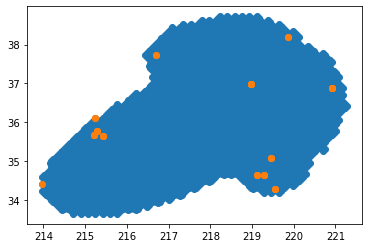

In [130]:
plt.scatter(ra_map, dec_map)
plt.scatter(ra_sn, dec_sn)

## Fancy coordinate matching *back* to ALERCE ledger
This must be done because the conversion from angle -> pixel -> angle is inexact in that we lose precision.
We solve this problem by using astropy's [match_coordinates_sky](https://docs.astropy.org/en/stable/api/astropy.coordinates.match_coordinates_sky.html), something you'll see frequently.

Currently only runs for SN but with a few changes (or more generalizing) can easily be run for AGN as well.

Plots/plotting code can be found at the very end because they take awhile.

In [132]:
# Convert RA's, DEC's to SkyCoord format

alerce_matches = SkyCoord(ra_sn*u.deg, dec_sn*u.deg) 
ledger_coords = SkyCoord(alerts_sn_ra*u.deg, alerts_sn_dec*u.deg)

# Run match
# match_coordinates_sky finds explicit 1-to-1 match between the two
idx_alerts, d2d, _ = match_coordinates_sky(alerce_matches, ledger_coords) # Not overkill... converting to and from pixels is not an exact operation!

sep_constraint = d2d <= 0.05*u.deg
#trans_matches = coo_trans_search[sep_constraint] # Don't need this but retaining for posterity
ledger_matches = ledger_coords[idx_alerts[sep_constraint]]
matches_ra_dec = list(zip(ledger_matches.ra.deg, ledger_matches.dec.deg))
#print(ledger_matches)
                      
assert len(ledger_matches) == len(alerce_matches), "Something went wrong grabbing the matches from the original catalog! Stopping (1)."

# Finds the indices of the matches in the original ledger and grabs those from the dataframe
ledger_ra_dec = list(zip(alerts_sn_ra, alerts_sn_dec))
#idx_alerts = [i for i, val in enumerate(ledger_ra_dec) if val[0] in ledger_matches.ra.deg and val[1] in ledger_matches.dec.deg] 
idx_alerts = [i for i, val in enumerate(ledger_ra_dec) if (val[0], val[1]) in matches_ra_dec] # or use df.apply and lambda function... it's fast enough here

# Dropping duplicates (there are quite a few)
alerce_rows = alerts_sn.loc[idx_alerts, :].sort_values(by='lastmjd').drop_duplicates(subset='oid')

assert len(alerce_rows) == len(set(ra_sn)), "Something went wrong grabbing the matches from the original catalog! Stopping (2)."

print(alerce_rows)

# for i in range(10):
#     print(alerce_matches[i].ra.deg) 
#     print(ledger_matches[i].ra.deg)#alerce_rows.iloc[i]["meanra"])

             oid ndethist  ncovhist  mjdstarthist    mjdendhist  corrected  \
0   ZTF21aapjkul       65      2002  59290.370532  59325.311898      False   
7   ZTF21aatdzug       27      1622  59307.345579  59325.366204      False   
64  ZTF21aayzkmp        3      1149  59338.308808  59339.235822       True   
65  ZTF21aazbfzr        1      1181  59339.286308  59339.286308      False   
36  ZTF18abiiqgm        8      1594  58319.186910  59342.359664       True   
66  ZTF20aajxfcy       30      1190  58642.256806  59349.295706      False   
9   ZTF21aarcldd      109      1605  59297.341609  59353.319607      False   
4   ZTF21abdhlfl        1      1838  59366.345602  59366.345602       True   
16  ZTF21abeeomw        2      1751  58831.507963  59370.260370      False   
47  ZTF18aaxvlkt        4      1658  58273.255567  59372.306065       True   
68  ZTF21aaqldsk      228      2889  58881.495857  59377.237512       True   
20  ZTF21abdbthn       23      1260  59363.236794  59377.299201 

#### Should be the same as above

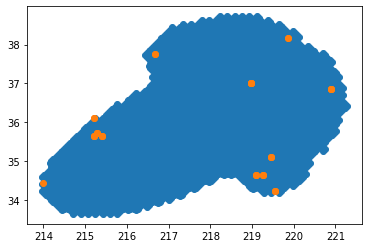

In [133]:
plt.scatter(ra_map, dec_map)
plt.scatter(ledger_matches.ra.deg, ledger_matches.dec.deg)

## Write ToO ledger to ecsv!

In [134]:
'''Checker is Matthew Portman/Antonella Palmese 
So if anything seems off... blame Antonella
.
.
.
if you dare.
'''
# Change filename
write_too_ledger('testing_ToO-Alerce.ecsv', alerce_rows, checker='MP/AP', overwrite=True, verbose=True, tabformat='ALERCE')

# %ECSV 0.9
# ---
# datatype:
# - {name: RA, unit: deg, datatype: float64}
# - {name: DEC, unit: deg, datatype: float64}
# - {name: PMRA, unit: mas / yr, datatype: float32}
# - {name: PMDEC, unit: mas / yr, datatype: float32}
# - {name: REF_EPOCH, unit: yr, datatype: float32}
# - {name: CHECKER, datatype: string}
# - {name: TOO_TYPE, datatype: string}
# - {name: TOO_PRIO, datatype: string}
# - {name: OCLAYER, datatype: string}
# - {name: MJD_BEGIN, unit: d, datatype: float64}
# - {name: MJD_END, unit: d, datatype: float64}
# - {name: TOOID, datatype: int32}
# meta: {DEPNAM00: desitarget, DEPNAM01: desitarget-git, DEPVER00: 0.53.0.dev4635, DEPVER01: 0.53.0-24-g58c9a719, EXTNAME: TOO, RELEASE: 9999}
# schema: astropy-2.0
RA DEC PMRA PMDEC REF_EPOCH CHECKER TOO_TYPE TOO_PRIO OCLAYER MJD_BEGIN MJD_END TOOID
220.896142  36.863934 0.000000 0.000000 2000.0 MP/AP FIELD HI BRIGHT 59325.31189810 59397.22230891 593250201
219.091965  34.643127 0.000000 0.000000 2000.0 MP/AP FIELD HI BRIGHT 59325.3

## Matching DESI observations to x% CI contour
This merely matches skymap angles to tile pointings and indicates which tiles matched and their program (bright/dark).

*The code does not currently write anything to file*

## The two *major* matching functions, **initial_check** and **inner_matching**
## Initial check
Performs the initial match with tile pointings. Grabs info from the exposures sql table, filters it, condenses by date, then sends all the good stuff to be matched via **inner_matching**. Finally outputs the results from that into a dictionary with the dates as keys and the sql table information as the values (sqlite3 row type, similar to a namedtuple/well-keyed dictionary). So there can be multiple elements as the values but only one key hence it's all organized by date. A convenient thing but also necessary for ALERCE efficiency.

e.g. {date:(exposure info)}

In [20]:
# From light_transient_matching, copy, pasted, and modified.

# Note, only matches 1-to-1. If you would like to find *all* matches in the area, set around = True and sit back.
# If you do set around = True, there are no data reduction methods in place yet so expect a lot of duplicates.

def initial_check(skymap_ra_in, skymap_dec_in, around = False) -> dict:
    
    # outputs a dictionary (desi_matches_dict) with keys as dates and values as sqlite3 rows containing the info grabbed from the exposures sql table
    # = {date:(exposure info)...}
    
    db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'

    # Per Antonella, no need to go further back
    query_date_start = "20201201"
    
    #today = Time.now()
    smushed_YMD = today.iso.split(" ")[0].replace("-","")
    
    query_date_end = smushed_YMD 

    # Handy queries for debugging/general information
    query2 = "PRAGMA table_info(exposures)"
    query3 = "PRAGMA table_info(tiles)"
    # Crossmatch across tiles and exposures to grab obsdate via tileid
    query_match = "SELECT distinct tilera, tiledec, obsdate, obsmjd, expid, program, exposures.tileid from exposures INNER JOIN tiles ON exposures.tileid = tiles.tileid where obsdate BETWEEN " + \
        query_date_start + " AND " + query_date_end + ";" #obsdate>20210228 

    # Querying sql and returning a data type called sqlite3 row, it's kind of like a namedtuple/dictionary
    conn = sqlite3.connect(db_filename)

    conn.row_factory = sqlite3.Row # https://docs.python.org/3/library/sqlite3.html#sqlite3.Row

    cur = conn.cursor()
    
    ''' ***** For handy purposes only *****
    
     cur.execute(query2)
     row2 = cur.fetchall()
     for i in row2:
         print(i[:])
    cur.execute(query)
    rows = cur.fetchall()
    
    *********************************** '''

    cur.execute(query_match)
    matches_list = cur.fetchall()
    cur.close()

    # I knew there was a way! THANK YOU!
    # https://stackoverflow.com/questions/11276473/append-to-a-dict-of-lists-with-a-dict-comprehension
    date_dict = {k['obsdate'] : list(filter(lambda x:x['obsdate'] == k['obsdate'], matches_list)) for k in matches_list}


    desi_matches_dict = {} # {i['obsdate']: [] for i in matches_list}
    all_confidence_matches = []
    
    # Uncomment the exp_ras/decs lines if retaining said coordinates is of interest (say for scatter plotting)
    # Or make a new function parameter... I quite like how clean it is now but up to you future user
    #all_exp_ras = []
    #all_exp_decs = []
    
    # Iterating day by day as a way to keep track
    for date, row in date_dict.items():
        #print(date)
        
        date_str = str(date)
        date_str = date_str[:4]+"-"+date_str[4:6]+"-"+date_str[6:] # Adding dashes for Time
        obs_mjd = Time(date_str).mjd

        # This method is *technically* safer than doing a double list comprehension with set albeit slower
        # The lists are small enough that speed shouldn't matter here
        # row has a separate element for all the tiles on that date
        unique_tileid = {i['tileid']:(i['tilera'], i['tiledec']) for i in row}
        exposure_ras, exposure_decs = zip(*unique_tileid.values())
        #all_exp_ras.extend(exposure_ras)
        #all_exp_decs.extend(exposure_decs)
        
        # **** Old method, deprecated ****
        #unique_ra_dec = list(set([(i[0], i[1]) for i in row])) # there's probably a way to do this in SQL... oh well
        #exposure_ras, exposure_decs = zip(*unique_ra_dec)
        # ********************************
        
        # Some renaming still to be done...
        #print(date)
        # Sends all the prepared information above to be matched and retains the coordinates of the matches
        desi_matches, confidence_matches = inner_matching(exposure_ras_in = exposure_ras, exposure_decs_in = exposure_decs, 
                                                              ra_in = skymap_ra_in, dec_in = skymap_dec_in, 
                                                              query_dates = query_date_start + query_date_end,
                                                              max_sep = 2, sep_units = 'deg', around = around)
        
        if desi_matches.size: # Interchangeable with confidence_matches
            # If any matches, print!
            print(date, '-', len(confidence_matches), 'match(es)')
            #print(len(confidence_matches), 'match(es)')
            if not around:
                all_confidence_matches.extend(confidence_matches) 
        else:
            continue

        desi_matches_dict[date] = []

        # Prepping output
        # Populating the dictionary by date (a common theme)
        # Each element in the dictionary thus contains the entire sqlite3 row (all info from sql tables with said headers)
        for tup in desi_matches:
            ra = tup.ra.deg
            dec = tup.dec.deg
            match_rows = [i for i in row if (i['tilera'], i['tiledec']) == (ra, dec)] # Just rebuilding for populating, this shouldn't change/exclude anything
            desi_matches_dict[date].extend(match_rows)
            
    return desi_matches_dict, all_confidence_matches #, all_exp_ras, all_exp_decs

## inner_matching
#### AKA 'the bread & butter'

**inner_matching** does the actual matching via **match_coordinates_sky**. It outputs a SkyCoord array containing the 1-to-1 matches for DESI and whatever the second 'catalog' is. 

It handles a little bit of prep including removing NaNs but for the most part simply performs the match and spits it back.

In [21]:
# Perform the actual matching with a bit of pre-conditioning to ensure happiness for everyone involved (looking at you astropy)
def inner_matching(exposure_ras_in = np.array([]), exposure_decs_in = np.array([]), ra_in = np.array([]), dec_in = np.array([]), 
                   max_sep = 2, sep_units = 'deg', around = False, query_dates = ""):
    
    # hashtag units
    if sep_units == 'arcsec':
        max_sep *= u.arcsec
    elif sep_units == 'arcmin':
        max_sep *= u.arcmin
    elif sep_units == 'deg':
        max_sep *= u.deg
    else:
        print("Separation unit specified is invalid for matching. Defaulting to arcsecond.")
        max_sep *= u.arcsec
    
    # Just in case
    if not np.array(exposure_ras_in).size:
        print('Array of size 0 fed in. Returning no matches.')
        return np.array([]), np.array([])
    
    # Removing nans because they don't place nice in match_coordinates_sky
    nan_ra = np.isnan(exposure_ras_in)
    nan_dec = np.isnan(exposure_decs_in)
    
    if np.any(nan_ra) or np.any(nan_dec):
        print("NaNs found, removing them from array (not FITS) before match.")
        #print("Original length (ra, dec): ", len(target_ras), len(target_decs))
        nans = np.logical_not(np.logical_and(nan_ra, nan_dec))
        exposure_ras_in = exposure_ras_in[nans] # Logic masking, probably more efficient
        exposure_decs_in = exposure_decs_in[nans]
    
    # Sometimes this comes in handy but the code runs fast enough these days
    tree_name = "_".join(("kdtree", query_dates))
    
    desi_coords = SkyCoord(exposure_ras_in*u.deg, exposure_decs_in*u.deg)
    catalog_coords = SkyCoord(ra_in*u.deg, dec_in*u.deg)
    
    # When running against the targlist this goes crazy... not worth it but I'll keep it in for posterity
    # Lots of repeats and not yet filtered because it may not be necessary to ever use this
    if around: 
        idx_desi, idx_catalog, d2d, d3d = catalog_coords.search_around_sky(desi_coords, max_sep)
        
        desi_matches = desi_coords[idx_desi] 
        catalog_matches = catalog_coords[idx_catalog]
        
    else:
        idx_catalog, d2d, d3d = match_coordinates_sky(desi_coords, catalog_coords) #, storekdtree = tree_name) # store tree to speed up subsequent results

        sep_constraint = d2d < max_sep
        desi_matches = desi_coords[sep_constraint]
        catalog_matches = catalog_coords[idx_catalog[sep_constraint]]
    
    
    #if desi_matches.size:
    #    print(len(desi_matches), "match(es) found with separation -", max_sep)
        #print()

    return desi_matches, catalog_matches

## Matching CI interval pixel locations to DESI tile pointings

In [22]:
#desi_matches, confidence_matches = initial_check(ra_map, dec_map)
desi_matches, _ = initial_check(ra_map, dec_map)

20210318 - 2 match(es)
20210319 - 2 match(es)
20210321 - 1 match(es)
20210403 - 1 match(es)
20210404 - 2 match(es)
20210405 - 1 match(es)
20210406 - 2 match(es)
20210407 - 1 match(es)
20210408 - 1 match(es)
20210409 - 1 match(es)
20210410 - 2 match(es)
20210412 - 2 match(es)
20210413 - 3 match(es)
20210414 - 2 match(es)
20210415 - 1 match(es)
20210416 - 2 match(es)
20210418 - 1 match(es)
20210419 - 1 match(es)
20210420 - 2 match(es)
20210428 - 2 match(es)
20210430 - 2 match(es)
20210501 - 1 match(es)
20210505 - 1 match(es)
20210506 - 1 match(es)
20210507 - 1 match(es)
20210514 - 3 match(es)
20210516 - 2 match(es)
20210519 - 2 match(es)
20210606 - 1 match(es)


## Print matched tile info (and Bright/Dark)
To be used later for plotting

In [23]:
#print('tilera, tiledec, obsdate, obsmjd, expid, tileid')

bd_tile_ras = []
bd_tile_decs = []
tileids = []

program_list = ['BRIGHT', 'DARK', 'BGS', 'ELG', 'QSO', 'LRG']
#all_tile_ras = []
#all_tile_decs = []
program_info = []

# Iterate through intial_check dictionary output
# k = date, not necessary here but retained out of habit
# v is the sqlite3 row info for each 2 degree matched tile
for k,v in desi_matches.items():
    for i in v:
        p_name = i['program']
        if any(substring in p_name.upper() for substring in program_list) and i['tileid'] not in tileids:
            print(i[:])
            bd_tile_ras.append(i['tilera'])
            bd_tile_decs.append(i['tiledec']) 
            program_info.append(i['program'])
            tileids.append(i['tileid'])

#no_repeats = [(i, j, k) for i,j,k in zip(tile_ras, tile_decs, program_info) if ]
#tile_ras = list(set(tile_ras))
#tile_decs = list(set(tile_decs))
print(len(bd_tile_ras))

(215.0, 32.375, 20210318, 59292.408191208, 80962, 'sv1elg', 80892)
(215.0, 32.375, 20210318, 59292.417332282, 80963, 'sv1lrgqso2', 80891)
(217.889, 34.495, 20210405, 59310.234805512, 83535, 'BRIGHT', 201)
(217.889, 34.495, 20210406, 59311.334602805, 83733, 'DARK', 190)
(217.655, 34.393, 20210407, 59312.320808641, 83875, 'DARK', 191)
(217.901, 34.314, 20210409, 59314.321635757, 84110, 'DARK', 192)
(217.732, 34.506, 20210410, 59315.304710501, 84230, 'DARK', 193)
(217.655, 34.393, 20210410, 59315.496617941, 84248, 'BRIGHT', 202)
(217.747, 34.288, 20210412, 59317.312443026, 84519, 'DARK', 194)
(217.901, 34.314, 20210412, 59317.397843528, 84527, 'BRIGHT', 203)
(217.732, 34.506, 20210413, 59318.353982358, 84647, 'BRIGHT', 204)
(217.937, 34.44, 20210413, 59318.488425866, 84660, 'DARK', 195)
(217.747, 34.288, 20210414, 59319.37051264, 84818, 'BRIGHT', 205)
(217.937, 34.44, 20210416, 59321.365551712, 85094, 'BRIGHT', 206)
(217.813, 34.52, 20210418, 59323.303979807, 85342, 'BRIGHT', 207)
(217.81

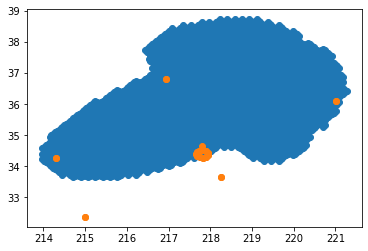

In [24]:
# Plotting the CI pixel map against the matched tiles from DESI
# These are only matched within 2 deg so edge matches are to be expected
plt.scatter(ra_map, dec_map)
plt.scatter(bd_tile_ras, bd_tile_decs)

## DR9 Targetlist Handling
This uses the same matching philosophy as in *light_transient_matching* in that it finds matches to tile pointings and then performs a second stage check to find individual targets. Two methods are offered, matching by RA/DEC and matching by TargetID. As mentioned earlier, RA/DEC seems more robust.

The target lists are built in the same way as [Segev's code](https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr9.ipynb)


In [25]:
# Read useful data from fits file, RA, DEC, target ID, and mjd as a leftover from previous use 
def read_fits_data(filepath: str, transient_candidate = True):
    
    if transient_candidate:
        hdu_num = 1
    else:
        hdu_num = 5
    
    try:
        with fits.open(filepath) as hdu1:
    
            data_table = Table(hdu1[hdu_num].data) #columns
        
            targ_ID = data_table['TARGETID']
            targ_ra = data_table['TARGET_RA'].data # Now it's a numpy array
            targ_dec = data_table['TARGET_DEC'].data
            
            #targ_mjd = data_table['MJD'][0] some have different versions of this so this is a *bad* idea... at least now I know the try except works!
            
            if not transient_candidate:
                targ_mjd = hdu1[hdu_num].header['MJD-OBS']
            
    except:
        filename = filepath.split("/")[-1]
        print("Could not open or use:", filename)
        print("In path:", filepath)
        print("Trying the next file...")
        return np.array([]), np.array([]), np.array([])
    
    if transient_candidate:
        targ_mjd = filepath.split("/")[-1].split("_")[-2] #to grab the date
        targ_mjd = targ_mjd[:4]+"-"+targ_mjd[4:6]+"-"+targ_mjd[6:] # Adding dashes for Time
        targ_mjd = Time(targ_mjd).mjd
    
    return targ_ra, targ_dec, targ_mjd, targ_ID

In [26]:
# Grabbing the frame fits files
def glob_frames(exp_d: str):   
    
    # This function grabs the names of all input files in the transient directory and does some python string manipulation
    # to grab the names of the input files with full path and the filenames themselves.

    try:
        filenames_read = glob.glob(exp_d + "/cframe-" + color_band + "*.fits") # Only need one of b, r, z
        # sframes not flux calibrated
        # May want to use tiles... coadd (will need later, but not now)
    
    except:
        print("Could not grab/find any fits in the exposure directory:")
        print(exp_d)
        filenames_read = [] # Just in case
        #filenames_out = [] # Just in case
        raise SystemExit("Exitting.")
        
    #else:
        #filenames_out = [s.split(".")[0] for s in filenames_read]
        #filenames_out = [s.split("/")[-1] for s in filenames_read]
        #filenames_out = [s.replace("in", "out") for s in filenames_out]
        
    return filenames_read #, filenames_out

#path_to_transient = "/global/cfs/cdirs/desi/science/td/daily-search/desitrip/out"
#print(all_candidate_filenames(path_to_transient)[1])

## Closer checking (handler) function
In the algorithm, **initial_check** has already been run and has produced a dictionary of DESI matches and 1-to-1 targetlist matches. Using said dictionary, we only check the dates/tiles in which we found a match and then compare all 5000 fibers to the whole targetlist again to save on operation time and memory.

This function handles via **glob_frames** and **read_fits_data** FITS I/O and feeds that directly into **inner_matching** to perform the actual match. So technically it doesn't actually perform the matching but it's the handler. 

It ultimately outputs two lists, one with the DESI exposure matches and the other with matches to the second catalog. In this case, the first (DESI) isn't needed so that will be all but empty while the second has the necessary info.

In [27]:
def closer_check(matches_dict = {}, catalog2_ras = [], catalog2_decs = [], exclusion_list = []):
    
    # Initalizing output structures
    all_exp_matches = {}
    all_targlist_matches = []
    
    # Just in case
    if not matches_dict:
        print("No far matches fed in for nearby matching. Returning none.")
        return {}
    
    # Iterate through dictionary from initial_check
    for date, row in matches_dict.items(): 
        print("\n", date)
        
        # If I have to run this multiple times, I probably already know what days there won't be a match so this is to save time
        if date in exclusion_list:
            continue

        all_exp_matches[date] = []
        file_indices = {}

        all_targ_ras = np.array([])
        all_targ_decs = np.array([])

        # Iterating tile by tile and grabbing all of the necessary info
        for i in row:
            exp_paths = '/'.join((exposure_path, "daily/exposures", str(i['obsdate']), "000"+str(i['expid'])))
            #print(exp_paths)
            
            # Now finally going file by file and putting all of those ras/decs into one giant numpy array
            # It should start making sense why we go date by date now... :)
            for path in glob_frames(exp_paths):
                #print(path)
                targ_ras, targ_decs, _, _ = read_fits_data(path, False)

                # For comparing to data tables in original file/sanity checking
                all_len = len(all_targ_ras)
                new_len = len(targ_ras)
                if all_len:
                    all_len -= 1
                    file_indices[path] = (all_len, all_len + new_len) # The start and end index, modulo number
                else:
                    file_indices[path] = (0, new_len) # The start and end index, modulo number

                if len(targ_ras) != len(targ_decs):
                    print("Length of all ras vs. all decs do not match.")
                    print("Something went wrong!")
                    print("Continuing but not adding those to match...")
                    continue

                all_targ_ras = np.append(all_targ_ras, targ_ras)
                all_targ_decs = np.append(all_targ_decs, targ_decs)

        # Here we finally perform the match, re-using inner_matching but with a much more strict matching radius
        desi_dict_matches, targlist_fiber_matches = \
            inner_matching(exposure_ras_in = all_targ_ras, exposure_decs_in = all_targ_decs,
                ra_in = catalog2_ras, dec_in = catalog2_decs, 
                max_sep = 1, sep_units = 'arcsec', around = False, query_dates = "")

        if targlist_fiber_matches:
            print(len(targlist_fiber_matches), "matches")
            all_targlist_matches.extend(targlist_fiber_matches)
        else:
            print("No matches found. Continuing...")
            continue
        
        # Prepping the output -- Not used here but kept for posterity
        '''
        for match_idx in range(len(desi_dict_matches)):
            match_ra = desi_dict_matches[match_idx].ra.deg
            match_dec = desi_dict_matches[match_idx].dec.deg
            
            # Since it's a pain to retrieve the index from the table, it'll be easier to match it after the fact with np.where
            location = np.where(match_ra == all_targ_ras)[0][0] # VERY unlikely to have a duplicate in the RA, I think this is safe
            
            targlist_ra = targlist_fiber_matches[match_idx].ra.deg
            targlist_dec = targlist_fiber_matches[match_idx].dec.deg
        
            # Prepping for DESI match output
            # Not really used here but kept for posterity
            for k, v in file_indices.items():
                if location in range(v[0], v[1]):
                    
                    # filepath, (ra,dec) for match, loc + 1 because fits indexing starts at 1, (RA, DEC) for targlist
                    match_info = (k.split("/")[-1], (match_ra, match_dec), (location + 1) % (v[1] - v[0]), (targlist_ra, targlist_dec))
                    
                    if match_info not in all_exp_matches[date]:
                        all_exp_matches[date].append(match_info)
        ''' 
    return all_exp_matches, all_targlist_matches

## Building the DR9 targetlist 

In [28]:
# Borrowed from Segev's code, thanks Segev! 
# https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr9.ipynb

def build_targlist_table(nside, pix_map):
    hpdirnames = ['/global/project/projectdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright',
                  '/global/project/projectdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/dark']

    readcols = ['TARGETID', 'BRICKID', 'BRICKNAME', 'BRICK_OBJID',
                'RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH',
                'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET',
                'FLUX_G', 'FLUX_R', 'FLUX_Z',
                'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z']

    targlist_threshold = None
    for hpdirname in hpdirnames:
        if targlist_threshold is None:
            targlist_threshold = Table(io.read_targets_in_hp(hpdirname, nside = nside, pixlist=pix_map, columns=readcols))
        else:
            targlist_threshold = vstack(targlist_threshold, Table(io.read_targets_in_hp(hpdirname, nside = nside, pixlist=pix_map, columns=readcols)))

    # targlist90.rename_column('BRICK_OBJID', 'OBJID')
    targlist_threshold = unique(targlist_threshold)
    
    return targlist_threshold

In [29]:
def targlist_write(table_in, filename, overwrite = True):
    # building the table takes *forever*
    # if overwrite = True, then overwrites regardless
    # if false, checks if the tables are equivalent and does nothing if they are
    # otherwise appends a 1 to the filename and writes
    # So if this were to happen a bunch you'd have xyz1111111.ecsv ;)
    
    if not overwrite:
        try:
            table_read = Table.read(filename)
        except:
            print("Can't find table specified per", filename)
            print("Writing a new one to", filename)
            overwrite = True

    if overwrite:
        table_in.write(filename, overwrite = True)
    else:
        if setdiff(table_in, table_read): # If there are differences
            name, ext = filename.split('.')
            name += "1"
            table_in.write(".".join((name, ext)))
    
    return None

In [30]:
# Some nifty commands for revisiting/rebuilding after the kernel has shutdown

rebuild = False
write_new = False
overwrite = False
read_in = True

if rebuild:
    targlist = build_targlist_table(gw_properties["nside"], pixmap)

if write_new:
    targlist_write(targlist, 'targlist' + CI_val + '_dr9_' + gw_name + '.ecsv', overwrite)
    
if read_in:
    targlist = Table.read('targlist' + CI_val + '_dr9_' + gw_name + '.ecsv')

## Initial matching via tile pointings then close match via fibers

In [31]:
m_dict, _ = \
    initial_check(np.array(targlist['RA']), np.array(targlist['DEC']))
#targlist_matches_red = \
#    SkyCoord(list(set([(val.ra.deg, val.dec.deg) for val in targlist_matches])), unit = 'deg')

20210318 - 2 match(es)
20210319 - 2 match(es)
20210321 - 1 match(es)
20210403 - 1 match(es)
20210404 - 2 match(es)
20210405 - 1 match(es)
20210406 - 2 match(es)
20210407 - 1 match(es)
20210408 - 1 match(es)
20210409 - 1 match(es)
20210410 - 2 match(es)
20210412 - 2 match(es)
20210413 - 3 match(es)
20210414 - 2 match(es)
20210415 - 1 match(es)
20210416 - 2 match(es)
20210418 - 1 match(es)
20210419 - 1 match(es)
20210420 - 2 match(es)
20210428 - 2 match(es)
20210430 - 2 match(es)
20210501 - 1 match(es)
20210505 - 1 match(es)
20210506 - 1 match(es)
20210507 - 1 match(es)
20210514 - 3 match(es)
20210516 - 2 match(es)
20210519 - 2 match(es)
20210606 - 1 match(es)


In [32]:
#print('tilera, tiledec, obsdate, obsmjd, expid, tileid')
# Generating lists of ras, decs, and program info for later graphing
# Could be stored in a single numpy array but it's been awhile and I need to brush up first :)

targetlist_tile_ras = []
targetlist_tile_decs = []
targ_program_info = []
tileids = []

program_list = ['BRIGHT', 'DARK', 'BGS', 'ELG', 'QSO', 'LRG']

# Iterate through intial_check dictionary output
# k = date, not necessary here but retained out of habit
# v is the sqlite3 row info for each 2 degree matched tile
for k,v in m_dict.items():
    for i in v:
        p_name = i['program']
        # checking program names and avoiding repeats
        if any(substring in p_name.upper() for substring in program_list) and i['tileid'] not in tileids:
            print(i[:])
            targetlist_tile_ras.append(i['tilera'])
            targetlist_tile_decs.append(i['tiledec']) 
            targ_program_info.append(i['program'])
            tileids.append(i['tileid'])

print(len(targetlist_tile_ras))

(215.0, 32.375, 20210318, 59292.408191208, 80962, 'sv1elg', 80892)
(215.0, 32.375, 20210318, 59292.417332282, 80963, 'sv1lrgqso2', 80891)
(217.889, 34.495, 20210405, 59310.234805512, 83535, 'BRIGHT', 201)
(217.889, 34.495, 20210406, 59311.334602805, 83733, 'DARK', 190)
(217.655, 34.393, 20210407, 59312.320808641, 83875, 'DARK', 191)
(217.901, 34.314, 20210409, 59314.321635757, 84110, 'DARK', 192)
(217.732, 34.506, 20210410, 59315.304710501, 84230, 'DARK', 193)
(217.655, 34.393, 20210410, 59315.496617941, 84248, 'BRIGHT', 202)
(217.747, 34.288, 20210412, 59317.312443026, 84519, 'DARK', 194)
(217.901, 34.314, 20210412, 59317.397843528, 84527, 'BRIGHT', 203)
(217.732, 34.506, 20210413, 59318.353982358, 84647, 'BRIGHT', 204)
(217.937, 34.44, 20210413, 59318.488425866, 84660, 'DARK', 195)
(217.747, 34.288, 20210414, 59319.37051264, 84818, 'BRIGHT', 205)
(217.937, 34.44, 20210416, 59321.365551712, 85094, 'BRIGHT', 206)
(217.813, 34.52, 20210418, 59323.303979807, 85342, 'BRIGHT', 207)
(217.81

In [33]:
# As a reminder, uses original targlist data to find 1 arcsecond matches to individual targets via fibers
desi_target_matches, targlist_target_matches = \
    closer_check(matches_dict = m_dict, catalog2_ras = np.array(targlist['RA']), \
    catalog2_decs =  np.array(targlist['DEC']))

# For when 'around = True'... but as commented earlier, that's a *bad* idea in this case
    #closer_check(matches_dict = m_dict, catalog2_ras = targlist_matches.ra.deg, \
    #catalog2_decs = targlist_matches.ra.deg)


 20210318
52 matches

 20210319
104 matches

 20210321
26 matches

 20210403
16 matches

 20210404
64 matches

 20210405
NaNs found, removing them from array (not FITS) before match.
2334 matches

 20210406
NaNs found, removing them from array (not FITS) before match.
226 matches

 20210407
NaNs found, removing them from array (not FITS) before match.
168 matches

 20210408
NaNs found, removing them from array (not FITS) before match.
168 matches

 20210409
NaNs found, removing them from array (not FITS) before match.
172 matches

 20210410
NaNs found, removing them from array (not FITS) before match.
2274 matches

 20210412
NaNs found, removing them from array (not FITS) before match.
1990 matches

 20210413
NaNs found, removing them from array (not FITS) before match.
3684 matches

 20210414
NaNs found, removing them from array (not FITS) before match.
5100 matches

 20210415
NaNs found, removing them from array (not FITS) before match.
1360 matches

 20210416
NaNs found, removing t

In [34]:
# Some data reduction to avoid repeats (there's quite a lot!)
unique_targlist_target_matches = \
    SkyCoord(list(set([(val.ra.deg, val.dec.deg) for val in targlist_target_matches])), unit = 'deg')
# targetid
print(len(targlist))
print(len(targlist_target_matches))
print(len(unique_targlist_target_matches))

42784
46986
16664


## Reducing the targetlist by previous observations

In [35]:
# Convert targetlist matches to a Table to take advantage of astropy's setdiff method
tlist_matches_table = Table([SkyCoord(unique_targlist_target_matches).ra.deg, 
                             SkyCoord(unique_targlist_target_matches).dec.deg], names = ('RA', 'DEC'))

#print(Table(targlist_matches))
targlist_radec_reduced = setdiff(targlist['RA', 'DEC'], tlist_matches_table)

assert len(targlist_radec_reduced) == len(targlist) - len(unique_targlist_target_matches), "Something went wrong masking the dr9 target list! Stopping."
print('{:.2f}% of targets have already been observed within 2 degrees of DESI tile pointing in {} CI.'.format(100*len(unique_targlist_target_matches)/len(targlist), CI_val))

38.95% of targets have already been observed within 2 degrees of DESI tile pointing in 90 CI.


## Writing to ToO ecsv

This may take awhile, it's likely a lot of targets that we have yet to observe.

In [36]:
#targlist_write(targlist_radec_reduced, "dr9_targlist" + CI_val + "_reduced_radec.ecsv", overwrite = True)

In [37]:
# Write dr9 targets to ecsv
write_too_ledger(filename = 'testing_ToO-bgs.ecsv', too_table = targlist_radec_reduced.to_pandas(), checker='MP/AP', overwrite=True, verbose=False, tabformat='LEGACY')

## Reduce targetlist using targetid

Seemingly less robust than RA/DEC but still worth holding onto. Somewhat faster but not as fast as one might hope (there is probably a quicker method to doing this however so don't take my word on speed until that alternative has been fully investigated (if it is ever investigated)) 

In [38]:
# Operates in a similar fashion to closer_check, just with targetids
# Also uses setdiff because I like it and I can iteratively reduce the original targetlist with little fuss and have it done
def grab_desi_targetid(matches_dict = {}, targlist_table = Table(), exclusion_list = []):
    
    if not targlist_table:
        print("No targetlist table fed in. Exitting and returning empty table.")
        return targlist_table
    
    if not matches_dict:
        print("No far matches fed in for targetid matching. Returning an empty table.")
        return Table()
    
    # For calling setdiff
    # I don't overwrite targlist_table... just in case... out of habit... because I'm scared
    table_reduced_targids = targlist_table
    
    for date, row in matches_dict.items(): 
        
        print(date)
        if date in exclusion_list:
            continue
            
        target_ids_date = []

        for i in row:
            exp_paths = '/'.join((exposure_path, "daily/exposures", str(i['obsdate']), "000"+str(i['expid'])))
            #print(exp_paths)
            #all_exp_fits[date].extend()
            for path in glob_frames(exp_paths):
                #print(path)
                _, _, _, target_ids = read_fits_data(path, False)

                target_ids_date.extend(target_ids)

        # Convert targetids to astropy table
        target_ids_date = np.array(target_ids_date, dtype = 'longlong')
        DESI_targ_id_table = Table([target_ids_date], names = ['TARGETID'])
        #targetid_matches = setdiff(targlist_table['TARGETID'], DESI_targ_id_table)
        
        # Perform setdiff
        reduced_targids = setdiff(table_reduced_targids, DESI_targ_id_table, keys = ['TARGETID'])
        if reduced_targids: # Since setdiff will return an empty table if there are no matches... which would overwrite everything
            table_reduced_targids = reduced_targids 
        else:
            print("No targetid matches found on:", date)
            
    return table_reduced_targids

In [39]:
targlist_targetid_reduced = grab_desi_targetid(matches_dict = m_dict, targlist_table = targlist, exclusion_list = [])

20210318
20210319
20210321
20210403
20210404
20210405
20210406
20210407
20210408
20210409
20210410
20210412
20210413
20210414
20210415
20210416
20210418
20210419
20210420
20210428
20210430
20210501
20210505
20210506
20210507
20210514
20210516
20210519
20210606


In [40]:
print(len(targlist))
print(len(targlist_targetid_reduced))

print('{:.2f}% of targets have already been observed within 2 degrees of DESI tile pointing in {} CI.'.format(100*(len(targlist) - len(targlist_targetid_reduced))/len(targlist), CI_val))

42784
26475
38.12% of targets have already been observed within 2 degrees of DESI tile pointing in 90 CI.


## Writing to ToO ecsv

In [41]:
# Print reduced targlist to file
#targlist_write(targlist_targetid_reduced, "dr9_targlist" + CI_val +"_reduced_targetid.ecsv", overwrite = True)
write_too_ledger(filename = 'testing_by_targetid_ToO-bgs.ecsv', too_table = targlist_targetid_reduced.to_pandas(), checker='MP/AP', overwrite=True, verbose=False, tabformat='LEGACY')

## Plotting GW map things

These take awhile so I placed them at the bottom so as to avoid accidentally running them and having to wait.

## Plotting the SN and AGN matches in CI area
And saves!

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

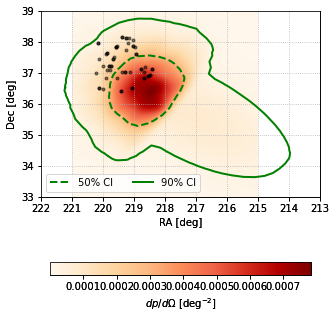

In [42]:
ra_list = [ra_sn, ra_agn]
dec_list = [dec_sn, dec_agn]
filename_suffix = ['SN', 'AGN']

for i in range(len(filename_suffix)):
    fig = plot_cartmap(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = ra_list[i], targ_dec = dec_list[i], angsize = 3)
    #fig = plt.figure()
    ax = fig.gca()
    ax.set(xlim=(222, 213), ylim=(33,39))
    plt.savefig(gw_name + '_alerce_' + filename_suffix[i] + '.png', dpi=120)

## Plot Cartmap for tiles and FOV in CI contour

Plots contours of CIs, Bright/Dark pointings, DESI FOV, and lastly saves!

In [43]:
# Borrowed from gw_skymap.py and modified

def plot_cartmap_tiles(lvc_healpix_file, levels=[0.5, 0.9], angsize=3., tile_ra=None, tile_dec=None, targ_ra=None, targ_dec=None, program_names = None):
    """Plot the GW map with the DESI footprint in a Cartesian projection.
    
    Parameters
    ----------
    lvc_healpix_file : str
        Relative or absolute path to LIGO/Virgo HEALPix angular reconstruction file.
    levels : list
        List of credible interval thresholds, e.g., 0.5, 0.9, etc.
    angsize : float
        Size of plot (-angsize, +angsize) in degrees about the center.
    tile_ra : list or ndarray
        List of RAs for DESI tiles (in deg).
    tile_dec : list or ndarray
        List of declinations for DESI tiles (in deg).
    targ_ra : list or ndarray
        List of RAs for DESI targets (in deg).
    targ_dec : list or ndarray
        List of declinations for DESI targets (in deg).
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object for accessing or saving a plot.
    """
    gwmap = hp.read_map(lvc_healpix_file)
    npix = len(gwmap)
    nside = hp.npix2nside(npix)

    # Compute contours.
    if nside > 256:
        _gwmap = hp.pixelfunc.ud_grade(gwmap, 256)
        _gwmap = _gwmap / np.sum(_gwmap)
    else:
        _gwmap = gwmap
    ra_contour, dec_contour = compute_contours(levels, _gwmap)

    # Create a temporary plot to produce a nice image array.
    # This code sets the size of the map around the maximum value.
    maxpix = np.argmax(gwmap)
    ra_c, dec_c = hp.pix2ang(nside, maxpix, lonlat=True)

    xmin = np.round(ra_c - angsize)
    xmax = np.round(ra_c + angsize)
    if xmax < xmin:
        xmin, xmax = xmax, xmin
    cxmin, cxmax = xmin, xmax
    frot = 0.
    if xmax > 90 and xmax < -90:
        frot, cxmin, cmax = 180., xmax-180., xmax+180.
    ymin = np.round(dec_c - angsize)
    ymax = np.round(dec_c + angsize)

    faspect = np.abs(cxmax - cxmin)/np.abs(ymax-ymin)
    fysize = 4
    figsize = (fysize*faspect+1, fysize+2)

    # Open and close the temporary plot.
    tfig   = plt.figure(num=2,figsize=figsize)
    rotimg = hp.cartview(gwmap, fig=2,coord='C', title="", cbar=False, flip='astro',
                         lonra=[cxmin,cxmax], latra=[ymin,ymax], rot=frot,
                         notext=True, xsize=1000,
                         return_projected_map=True)
    plt.close(tfig)

    # Now make the real plot with the desired angular contours.
    fig, ax = plt.subplots(1,1, num=1, figsize=figsize)
    img = ax.imshow(rotimg, extent=[cxmax, cxmin, ymin, ymax],
                    origin='lower', cmap='OrRd')

    for i, (rc, dc, lstyle, clev) in enumerate(zip(ra_contour, dec_contour, ['--', '-'], ['50', '90'])):
        p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=2, label='{}% CI'.format(clev))

    ax.set(xlim=(cxmax, cxmin),
       xlabel='RA [deg]',
       ylabel='Dec [deg]')
    ax.grid(ls=':')
    
    bright_list = ['BRIGHT', 'BGS']
    dark_list = ['DARK', 'ELG', 'QSO', 'LRG']
    # Add DESI targets, specified by RA, Dec.
    if targ_ra is not None and targ_dec is not None:
        if program_names:
            
            # if bright in program_info or if '---'.lower() == bgs, then plot as bright
            # if dark in ... or if ''.lower() == elg or qso or lrg
            
            bright_pointing = np.array([(i,j) for i,j,k in zip(targ_ra, targ_dec, program_names) if any(substring in k.upper() for substring in bright_list)])
            dark_pointing = np.array([(i,j) for i,j,k in zip(targ_ra, targ_dec, program_names) if any(substring in k.upper() for substring in dark_list)])
            
            bright_dots = ax.plot(bright_pointing[:, 0], bright_pointing[:, 1], 'c.', alpha = 1, label = 'BRIGHT', marker = "+") 
            dark_dots = ax.plot(dark_pointing[:, 0], dark_pointing[:, 1], 'm.', alpha = 0.7, label = 'DARK', marker = "x") 
            
        else:
            ax.plot(targ_ra, targ_dec, 'k.', alpha=0.5, label = 'Matches') # temp change, alpha = 0.1 -> alpha = 0.5 (maybe push command line arg for this)

    _h, _l = ax.get_legend_handles_labels()

    # Add DESI tile drawings, specified by central RA, Dec.
    if tile_ra is not None and tile_dec is not None:
        #for _ra_c, _dec_c in zip(tile_ra, tile_dec):
        for _ra_c, _dec_c in zip(targ_ra, targ_dec):
            circ = plt.Circle((_ra_c, _dec_c), radius=1.6, fc='None', ec='b', ls=':', lw=2)
            ax.add_artist(circ)

        _h.append(circ)
        _l.append('DESI FOV')
    
    ax.legend(handles=_h, labels=_l, fontsize=10, ncol=2)

    cb = fig.colorbar(img, orientation='horizontal', shrink=0.95,
                      fraction=0.04, pad=0.2, ax=ax)
    cb.set_label(r'$dp/d\Omega$ [deg$^{-2}$]')

    return fig

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

[(33.0, 40.0), (222.0, 213.0)]

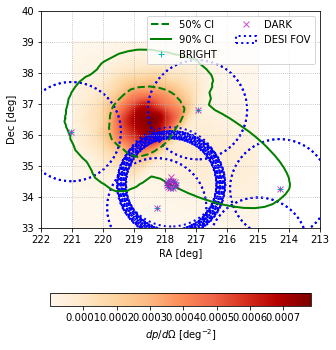

In [44]:
fig = plot_cartmap_tiles(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = bd_tile_ras, targ_dec = bd_tile_decs, angsize = 3, program_names = program_info)
ax = fig.gca()
ax.set(xlim=(222, 213), ylim=(33,40))
#ax.scatter(exp_ras, exp_decs)
#ax.scatter(targlist_radec_reduced['RA'], targlist_radec_reduced['DEC'], alpha = 0.2, s = 0.3)
plt.savefig(gw_name + '_desi_tile-matches.png', dpi=120)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

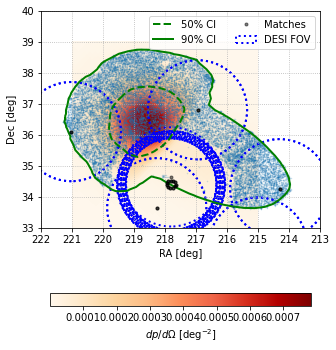

In [45]:
# Plot targetlist tile matches and DESI FOV, just in case 
fig = plot_cartmap_tiles(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = targetlist_tile_ras, targ_dec = targetlist_tile_decs, angsize = 3, program_names = [])#program_info)
ax = fig.gca()
ax.set(xlim=(222, 213), ylim=(33,40))
ax.scatter(targlist_radec_reduced['RA'], targlist_radec_reduced['DEC'], alpha = 0.2, s = 0.3)
#ax.scatter(targlist['RA'], targlist['DEC'])
plt.savefig(gw_name + '_desi_tile-matches.png', dpi=120)